## Реализация стратегий линейного поиска в методе градиентного спуска и методе Ньютона
### Дятлова Дарья, 1 курс МОиАД ВШЭ¶

In [1]:
import numpy as np
import random 
import scipy
from scipy.special import expit
from sklearn.datasets import load_svmlight_file
import matplotlib.pyplot as plt
import functools
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
def counter(func):
    @functools.wraps(func)
    def inner(*args, **kwargs):
        inner.count += 1
        s_time = time.perf_counter()
        result = func(*args, **kwargs)
        inner.time = time.perf_counter() - s_time
        return result
    inner.count = 0
    inner.time = 0
    return inner

## Пункт 1

### Формулы

#### Запишем задачу в матричном виде.

### $$\sigma_w(x) = \frac{e^{f_w(x)}}{1 +  e^{f_w(x)}}$$

#### Где: $$f_w(x) = w^Tx$$

#### Дана функция: 

### $$f_w(x) = (- \frac{1}{N}) \cdot \sum y_i \cdot ln (\sigma_w(x_i)) + (1 - y_i) \cdot ln (1 - \sigma_w(x_i))$$

#### Рассмотрим первое слагаемое суммы:

#### $$ \sigma_{w(x_i)} = \frac{e^{(x_i)^T \cdot w}}{1 + e^{(x_i)^T \cdot w}} \Rightarrow \sigma_{w(x)} = \frac{e^{(x)^T \cdot w}}{1 + e^{(x)^T \cdot w}} $$ 

#### $$ Xw = ((x_1 w_1), ... , (x_m w_m))^T, $$ где $m$ – количество фич.

#### $$ln\sigma_w(x_w) = (ln(\sigma_w(x_1)), ..., ln(\sigma_w(x_n)))^T$$

#### Аналогично разложим второе слагаемое и запишем функцию $f_w(x)$ в следующем виде:

### $$f_w(x) =  - \frac{1}{N} \cdot (y^T ln(\sigma(x_w)) + (1 - y)ln(1 - \sigma(x_w)). $$

#### Запишем формулы для вычисления градиента и гессиана функции в матричном виде:

#### $$\vec \nabla f(w) = X \cdot (\sigma (w X) - y)$$

#### $$\vec H(w) = \vec \nabla^2 f(w) = XX^T \cdot \sigma(w X) \cdot (1 - (\sigma (w X))) = X D X^T,$$ 

#### где $D$ – квадратная диагональная матрица с элементами $d_{ii} =  \sigma(w X) \cdot (1 - (\sigma (w X))$

#### Выводы: 
- результат работы метода для логистической регрессии зависит от выбора начальной (значения вектора весов $w$). Это влияет на то, как скоро и насколько близко метод сойдется к минимуму.

In [386]:
def sigmoid(x: np.array):
    return expit(x)

## Пункт 2

#### Создадим класс Oracle и запишем необходимые методы исходя из формул в пункте 1.

In [392]:
class Oracle:
    
    def __init__(self, X, y):       
        self.X = X.copy()
        self.y = y.copy()
        
    @counter
    def value(self, w):
        eps = 1e-8
        res = (- 1 / self.X.shape[0]) * ((self.y @ np.log(sigmoid(self.X @ w) + eps)) + ((1 - self.y) @ np.log(1 - sigmoid(self.X @ w) + eps)))
        return res
    
    @counter
    def grad(self, w):
        return (1 / self.X.shape[0]) * self.X.T @ (sigmoid(self.X @ w) - self.y)
    
    @counter
    def hessian(self, w):
        d = sigmoid(self.X @ w) * (1 - sigmoid(self.X @ w)) 
        D = np.diagflat(d)
        return (1 / self.X.shape[0]) * (self.X.T @ (D @ self.X))
    
    @counter
    def hessian_vec_product(self, w, d):
        sigma = sigmoid(self.X @ w)
        vec = self.X @ d
        vec = np.diag(sigma * (1 - sigma)) @ vec
        return (1 / len(self.X[1])) * self.X.T @ vec 

    @counter
    def fuse_value_grad(self, x):
        return value(x), grad(x)

    @counter
    def fuse_value_grad_hessian(self, x):
        return value(x), grad(x), hessian(x)

    @counter
    def fuse_value_grad_hessian_vec_product(self, x, d):
        return value(x), grad(x), hessian_vec_product(x, d)

#### Загрузим датасет a1a и инициализируем вектор весов $w$ из 1, в дальнейшем будем использовать его для построения гарфиков. 

In [389]:
X, y = load_svmlight_file('a1a')
X = scipy.sparse.hstack((np.array([1 for _ in range(X.shape[0])])[:,None], X)).A

# change -1 for 0 in y
for i in range(len(y)): 
    if y[i] == -1:
        y[i] = 0
        
w = np.random.randint(1, 2, X.shape[1]).tolist()
w = np.array(w)

### Разностная проверка градиента и гессиана

In [34]:
f = Oracle(X, y)


def grad_test(w):
    e = [0 for i in range(X.shape[1])]
    values = [0 for i in range(X.shape[1])]
    for i in range(X.shape[1]):
        e[i] = 1e-8
        values[i] = (f.value(w + e) - f.value(w)) / (1e-8)**2
        e[i] = 0
           
    numbers = np.linspace(1, len(values), len(values))
           
    grad_err = f.grad(w) - values
           
    return grad_err, numbers


def hessian_test(w):
    
    
    e = 1e-16
    e_i = [0 for i in range(len(w))]
    e_j = [0 for i in range(len(w))]
    matrix = np.array([[0 for i in range(len(w))] for i in range(len(w))])
    
    for i in range (len(e_i)):
        for j in range (len(e_j)):
            e_i[i] = e**(1/3)
            e_j[j] = e**(1/3)
            matrix[i][j] = (f.value(w + np.array(e_i.copy()) + np.array(e_j.copy())) - f.value(w + np.array(e_i.copy())) - f.value(w + np.array(e_j.copy())) + f.value(w))/ e**(1/6)
            e_i[i] = 0
            e_j[j] = 0
            
            
    hess_err = f.hessian(w) - matrix
    l = (hess_err.shape[0])**2
    reshaped_hess = hess_err.reshape(1, l)
    
    numbers = np.linspace(1, len(reshaped_hess[0]), len(reshaped_hess[0]))
    
    return reshaped_hess[0], numbers

#### Построим графики для сравнения точности вычисления градиента и гессиана написанного в матричном виде с аналитическим решением:

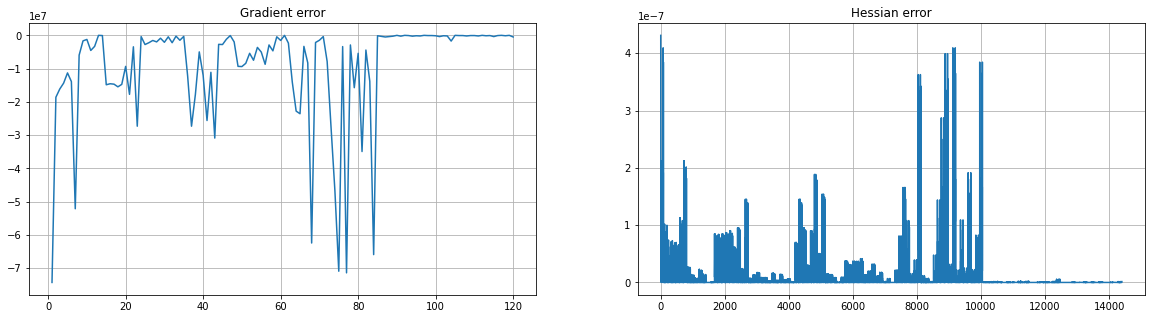

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))

# building plot to check hessian error 
err, numb = grad_test(w) 
grad_test(w)       
ax[0].grid(True)
ax[0].set_title('Gradient error')
ax[0].plot(numb, err)
#ax[0].set(xlabel('err'))
#ax[0].set(ylabel('n'))

            
# building plot to check hessian error 
err, numb = hessian_test(w) 
hessian_test(w)       
ax[1].grid(True)
ax[1].set_title('Hessian error')
ax[1].plot(numb, err)
#ax[1].set(errlabel='err')
#ax[1].set(numblabel='n')

plt.show()

#### Выводы:
- На графиках видно, что ошибка при вычислении градиента колеблится в районе 1e-7 при $n < 80$, однако снижается при росте n. Тоже происходит и с гессианом.

## Пункт 3

#### Запишем 5 стратегий linesearch для реализации градиентного спуска.

In [334]:
def armijo_gd(f, w, d):
    
    i, a, c, p = 1, 1, 0.001, 0.99
    
    while (i < 25):
        
        if f.value(w + (a * d)) > f.value(w) + (c * a * (f.grad(w) @ d)):         
            break
      
        else:
            a = p * a
            i += 1
            
    return a

In [335]:
def armijo_newton(f, w, d):
    
    i, a, c, p = 1, 1, 0.25, 0.25
    
    while (i < 25):
        
        if f.value(w + (a * d)) > f.value(w) + (c * a * (f.grad(w) @ d)):         
            break
       
        else:
            a = p * a
            i += 1
            
    return a

In [336]:
def wulff_newton(f, x, d, c1=0.0001, c2=0.9, amax=None):
    return scipy.optimize.line_search(f.value, f.grad, xk=x, pk=-d, c1=c1, c2=c2)[0]

In [337]:
def wulff_gd(f, w, d):
    
    return scipy.optimize.line_search(f.value, f.grad, w, d)[0]

In [338]:
def golden_section_gd(f, w, d):
    
    gs = (np.sqrt(5) + 1) / 2
    tol = 1e-8
    a, b = 0, 100
    
    x1 = b - (b - a) / gs
    x2 = a + (b - a) / gs  
    
    i = 0
    
    while abs(b - a) / 2 > tol:
        
        i += 1
        
        if (f.value(w + (x1 * d)) > f.value(w + (x2 * d))):
            a = x1
            
        else:
            b = x2
        x1 = b - (b - a) / gs
        x2 = a + (b - a) / gs
            
    return ((a + b) / 2)

In [339]:
def golden_section_newton(f, w, d):
    
    
    gs = (np.sqrt(5) - 1) / 2
    tol = 1e-8
    a, b = 0, 50
    
    P = (b - a) * gs
    left = b - P
    right = a + P

    while P > tol:
        f_l = f.value(w - left * d)
        f_r = f.value(w - right * d)

        if f_l >= f_r:
            a = left
            left = right
            P *= gs
            right = a + P
        else:
            b = right
            right = left
            P *= gs
            left = b - P

    return min(right, left)

In [340]:
def brent(f, w, d):
    
    def func(t):
        return f.value(w + t * d)
    
    x, a, i, c = scipy.optimize.brent(func, full_output = True)
    
    return x

In [341]:
def lipschitz(f, w):
    
    L, gamma, betta = 1, 1.5, 1.5
    i = 0
    
    for k in range(1000):      
        i += 1
        w_new = w - (1/L * f.grad(w))
        
        if f.value(w_new) <= f.value(w) + (f.grad(w) @ (w_new - w)) + ((L / 2) * (np.linalg.norm(w_new - w)**2)):
            return L
            break
            
        else:
            L = min(L, L * gamma)
            
            L = L / betta
            
    return L

### Теперь напишем сам градиентный спуск:

In [380]:
f = Oracle(X, y)

def get_f_optim_value(f, w):
    
    return scipy.optimize.minimize(f.value, w, jac=f.grad, tol=1e-8).fun

@counter
def line_search(f, w, d, m):
    
    if m == "Golden Section":
        a = golden_section_gd(f, w, d)    
        return a

    elif m == "Brent":
        a = brent(f, w, d)
        return a
    
    elif m == "Armijo":
        a = armijo_gd(f, w, d)
        return a
    
    elif m == "Wulf":
        a = wulff_gd(f, w, d)
        return a
    
    elif m == "Lipschitz":
        a = lipschitz(f, w)
        return a
    
    
@counter  
def gradient_descent(f, w0, method, data, tol=1e-8, k = 1000):
    
    arr_r1, arr_r2, history_time, history_oracle = [], [], [], []
    
    r2 = 1
    m = method
    w = w0
    grad_start = np.linalg.norm(f.grad(w0))
    d = -f.grad(w)
    f_optim_value = get_f_optim_value(f, w)
    
    for i in range(k):
        grad = f.grad(w)
        arr_r1.append(abs(f.value(w) - f_optim_value))
        arr_r2.append(r2)
        history_time.append(line_search.time)
        history_oracle.append(f.value.count)
        r2 = (np.linalg.norm(grad) / grad_start)**2
        
        if (np.linalg.norm(grad)**2 / (grad_start)**2) <= tol:
            break
            
        else:
            
            d = -f.grad(w)
            
            a = line_search(f, w, d, m)
                
            if d is None:
                d = 0.0001
            if a is None:
                a = 0.0001
                
            w = w + (a * d)
    
    data[method] = {
        "arr_r1": np.log(arr_r1),
        "arr_r2": np.log(arr_r2),
        "history_time": np.cumsum(history_time),
        "history_oracle": history_oracle,
    }

    return f.value(w)

#### Запустим градиентный спуск на датасете a1a с каждой стратегией с целью сравнить для всеx методов c $log_{r_k}$:
#### - время работы оракула;
#### - число вызовов оракула.

### $$r_k = |f(w_k) - f(w_*)|,$$

#### При построении графиков будем обозначать метрику $r_{k1}$

### $$r_k = \frac{|\nabla f(w_k)|^2}{|\nabla f(w_0)|^2}.$$

#### При построении графиков будем обозначать метрику $r_{k1}$

#### $f(w_*)$ – оптимальное решение. Вычислим его с помощью встроенной функции scipy:

In [241]:
Oracle(X, y)
def get_f_optim_value(f, w):
    return scipy.optimize.minimize(f.value, w, jac=f.grad, tol=1e-8).fun
w_optimal = get_f_optim_value(f, w)
print("Optimal value for dataset a1a:", w_optimal)

Optimal value for dataset a1a: 0.2978754392048716


#### Напишем функцию для сбора данных о количестве вызово оракла и времени работы градиентного спуска при выборе каждой из стратегий linesearch.

In [342]:
f = Oracle(X, y)
w = np.random.randint(1, 2, X.shape[1]).tolist()
w = np.array(w)

def grad_plot(f, w, data):
             
    plot_data = {}
    
    for method in data.keys():
        f.value.__dict__["count"] = 0
        res_w = gradient_descent(f, w, method, data)
        print('Strategy: ', method)
        print('Time: ', gradient_descent.time)
        print('Oracle runs: ', max(0, f.value.count))
        print('Function value', res_w, '\n')
        plot_data[method] = []
        plot_data[method].append((data[method]["history_time"], data[method]["arr_r1"], data[method]["arr_r2"]))  
        plot_data[method].append((data[method]["history_oracle"], data[method]["arr_r1"], data[method]["arr_r2"]))
        plot_data[method].append((np.arange(len(data[method]["arr_r1"])), data[method]["arr_r1"]))
        plot_data[method].append((np.arange(len(data[method]["arr_r2"])), data[method]["arr_r2"]))
        
    return plot_data  

#### Теперь напишем функцию для построения 4 графиков:
#### - $log r_{k1}$ от времени работы метода;
#### - $log r_{k2}$ от числа вызовов оракула;
#### - $log r_{k1}$ от времени работы метода;
#### - $log r_{k2}$ от числа вызовов оракула.

In [479]:
f = Oracle(X, y)

def plot_general(f, func, data):
    
    plot_data = func(f, w, data)
    for i in range(0, 2):
        for j in range(1, 3):
            plt.figure(figsize=(14,8))
            plt.grid(True)
            

            wu = plot_data['Wulf'][i][0]
            y_wu = plot_data['Wulf'][i][j]
            plt.plot(wu, y_wu, label='Wulf')
            
            if func == grad_plot:
              
                gs = plot_data['Golden Section'][i][0]
                y_gs = plot_data['Golden Section'][i][j]
                plt.plot(gs, y_gs, label='Golden Section')
                
                li = plot_data['Lipschitz'][i][0]
                y_li = plot_data['Lipschitz'][i][j]
                plt.plot(li, y_li, label='Lipschitz')
                
            if func == grad_plot or func == newton_plot:
              
                br = plot_data['Brent'][i][0]
                y_br = plot_data['Brent'][i][j]
                plt.plot(br, y_br, label='Brent')

                ar = plot_data['Armijo'][i][0]
                y_ar = plot_data['Armijo'][i][j]
                plt.plot(ar, y_ar, label='Armijo')
              
              
            if j == 1:
                plt.ylabel('r1')
            else:
                plt.ylabel('r2')
                
            if i == 0:
                plt.title("time")
                plt.xlabel('time taken')
            else:
                plt.title("oracle count")
                plt.xlabel('number of iterations')
                
            plt.legend(loc='upper left', shadow=True) 
            plt.show() 

### Построим соответсвующие графики для анализа работы стратегий linesearch при решении задачи линейной регрессии с помощью градиентоного спуска.

Strategy:  Golden Section
Time:  14.605038411988062
Oracle runs:  95678
Function value 0.30270148903377336 

Strategy:  Brent
Time:  4.351542082004016
Oracle runs:  21561
Function value 0.3027109188346146 

Strategy:  Armijo
Time:  12.367253899996285
Oracle runs:  49678
Function value 0.31347654373659867 

Strategy:  Wulf
Time:  2.032380506992922
Oracle runs:  5183
Function value 0.3021744386242436 

Strategy:  Lipschitz
Time:  1.7109282850142336
Oracle runs:  3678
Function value 0.31185526557231513 



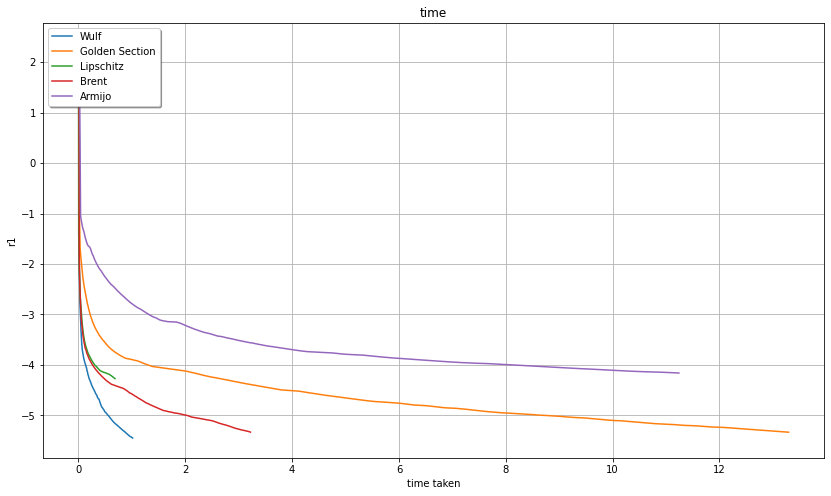

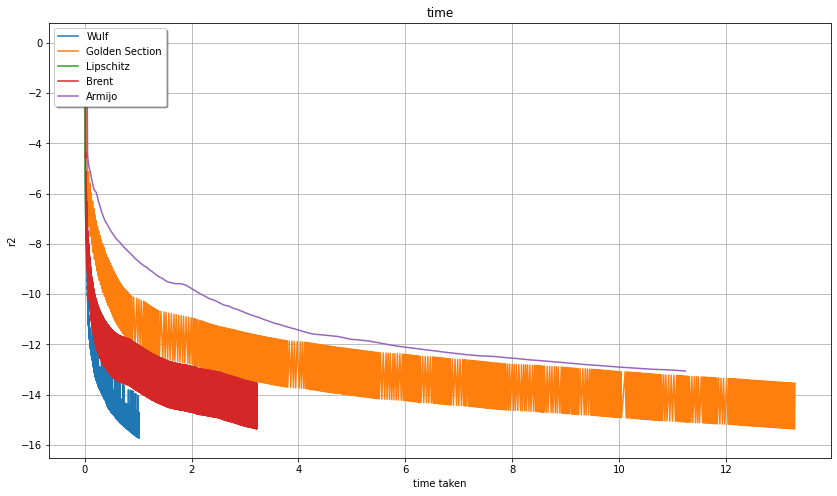

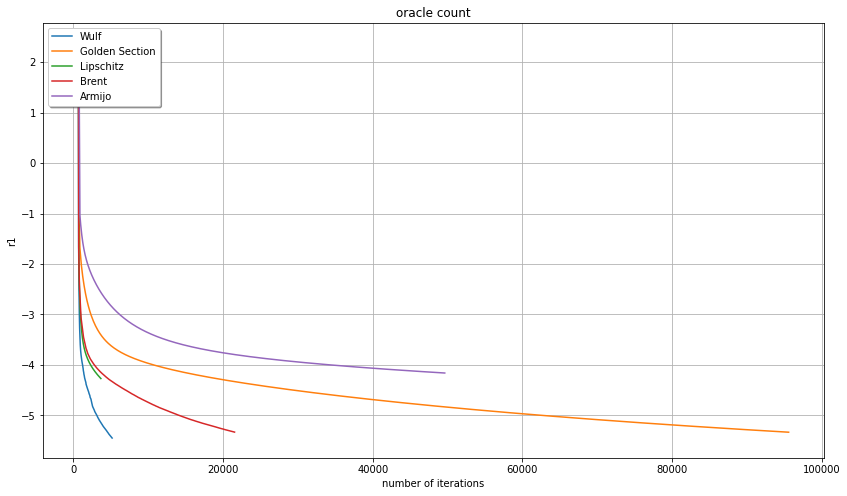

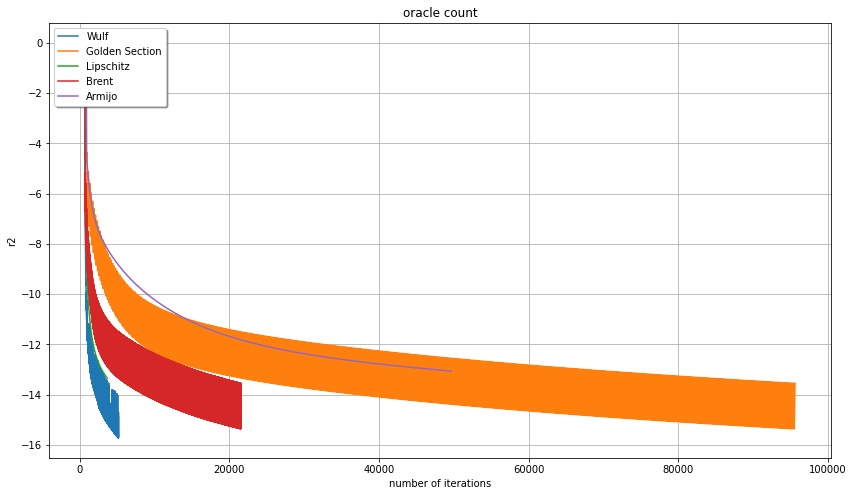

In [354]:
f = Oracle(X, y)
w = np.random.randint(1, 2, X.shape[1]).tolist()
w = np.array(w)

data = {
    "Golden Section": None,
    "Brent": None,
    "Armijo": None,
    "Wulf": None,
    "Lipschitz": None,
}

plot_general(f, grad_plot, data)

#### Выводы:
- На графиках видим, что градиентный спуск с методом золотого сечения работал дольше всех стратегий: 12 секунд. 
- Наиболее эффиктивным с точки зрения полученной точности и времени работы является Вульф. 
- Меньше всего вызовов оракула понадобилось Липшецу, чья точность также близка к Бренту. 
- Наимение точного результата мы добились со стратегией Армихо. Возможно, это связано с деталями реализации и выбранными нами параметрами.
- В целом, все методы дали нам решение отличающееся от оптимального в первом знаке после запятой.

## Пункт 5

#### Реализуем метод Ньютона и проведем схожий анализ с различными стратегиями linesearch на примере датасета a1a. В качестве стартовых весов возьмем вектор из 0.

In [286]:
f = Oracle(X, y)
w = np.random.randint(0, 1, X.shape[1]).tolist()
w = np.array(w)

def get_f_optim_value(f, w):
    return scipy.optimize.minimize(f.value, w, jac=f.grad, tol=1e-8).fun

@counter
def line_search(f, w, d, m):
    
    if m == "Golden Section":
        a = golden_section_newton(f, w, d)    
        return a

    elif m == "Brent":
        a = brent(f, w, d)
        return a
    
    elif m == "Armijo":
        a = armijo_newton(f, w, d)
        return a
    
    elif m == "Wulf":
        a = wulff_newton(f, w, d)
        return a

@counter
def get_d(w, grad, hess, tau): 
    
    L = None   
    E = np.identity(hess.shape[0])
    B = hess
    for i in range(30):
        B += tau * E   
        try:
            L = np.linalg.cholesky(B)
            break     
        except:
            tau = min(0.1, tau * 2)
            
    y = np.linalg.solve(L, grad)
    d = np.linalg.solve(L.T, y)
    return d
 
@counter 
def newton(f, w0, method, data_new):
    
    a_r1, a_r2, hist_time, hist_oracle = [], [], [], []
    w = w0
    grad, hess, grad_start = f.grad(w), f.hessian(w), np.linalg.norm(f.grad(w0))
    i, r2, tau, tol = 0, 1, 0.0001, 1e-8
    f_optim_value = get_f_optim_value(f, w)
    m = method
    
    for i in range(1000):
        grad = f.grad(w)
        a_r1.append(abs(f.value(w) - f_optim_value))
        a_r2.append(r2)
        hist_time.append(get_d.time)
        hist_oracle.append(get_d.count)
        r2 = (np.linalg.norm(grad) / grad_start)**2
        
        if (np.linalg.norm(grad)**2 / (grad_start)**2) <= tol:
            break
            
        else:        
            d = get_d(w, grad, hess, tau)

            a = line_search(f, w, d, m)  
            

            
        if d is None:
            d = 0.0001
        if a is None:
            a = 0.0001
            
        if m == "Brent":
            w = w + (a * d)
            
        else:
            w = w - (a * d)
            
        
            
    data_new[method] = {
        "a_r1": np.log(a_r1),
        "a_r2": np.log(a_r2),
        "hist_time": np.cumsum(hist_time),
        "hist_oracle": hist_oracle,
    }
              
    return f.value(w)

#### Напишем аналогичную функцию для сбора данных о числе вызовов оракула и времени работы метода Ньютона с использованием различных стратегий:

In [287]:
f = Oracle(X, y)
w = np.random.randint(0, 1, X.shape[1]).tolist()
w = np.array(w)

def newton_plot(f, w, data_new):
    plot_data = {}
    
    for method in data_new.keys():
        
        get_d.__dict__["count"] = 0
        f.value.__dict__["count"] = 0
        res_w = newton(f, w, method, data_new)
        print('Strategy: ', method)
        print('Time: ', newton.time)
        print('Oracle runs: ', max(0, f.value.count))
        print('Function value', res_w, '\n')
        plot_data[method] = []
        plot_data[method].append((data_new[method]["hist_time"], data_new[method]["a_r1"], data_new[method]["a_r2"]))  
        plot_data[method].append((data_new[method]["hist_oracle"], data_new[method]["a_r1"], data_new[method]["a_r2"]))
        plot_data[method].append((np.arange(len(data_new[method]["a_r1"])), data_new[method]["a_r1"]))
        plot_data[method].append((np.arange(len(data_new[method]["a_r2"])), data_new[method]["a_r2"]))
        
    return plot_data  


#### Построим графики для анализа работы 3 linesearch стратегий с методом Ньютона: Брента, Вульфа и Армихо.

Strategy:  Brent
Time:  4.109166629001265
Oracle runs:  22802
Function value 0.29810423660668695 

Strategy:  Armijo
Time:  1.6425207930005854
Oracle runs:  3677
Function value 0.2985322598612344 

Strategy:  Wulf
Time:  0.7902276969980448
Oracle runs:  1432
Function value 0.29819573567508567 



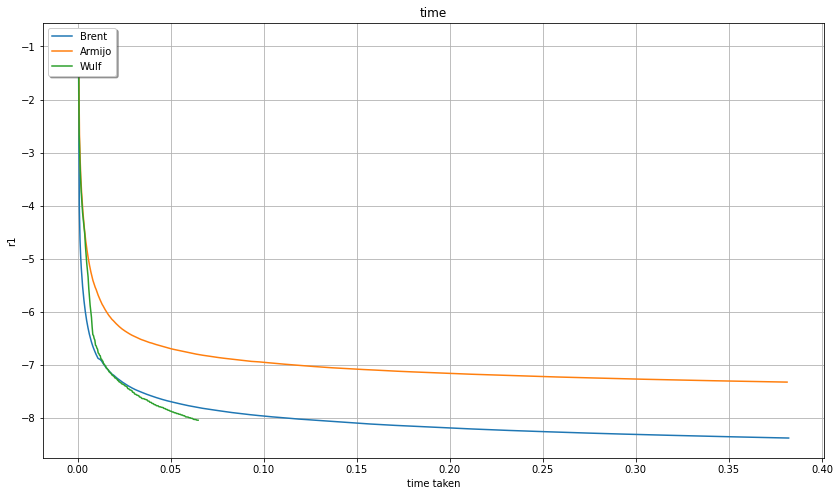

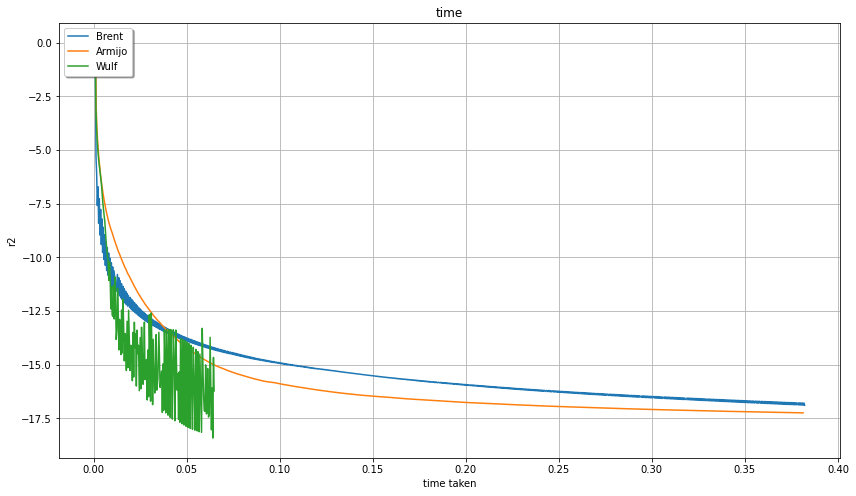

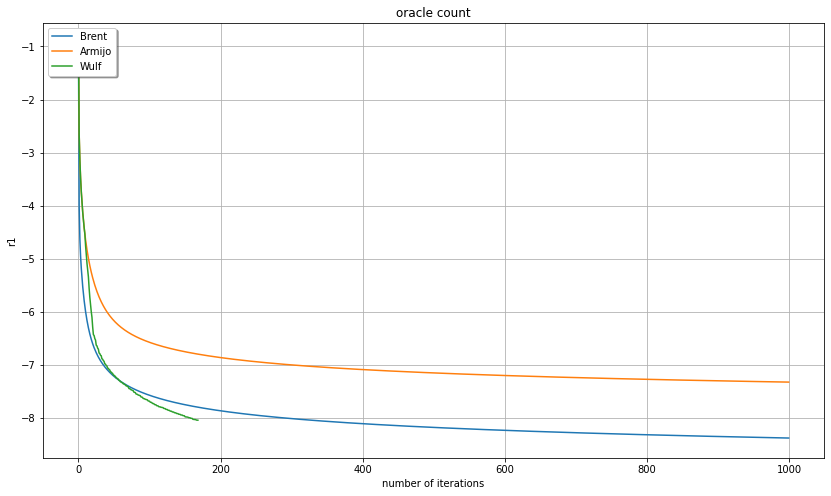

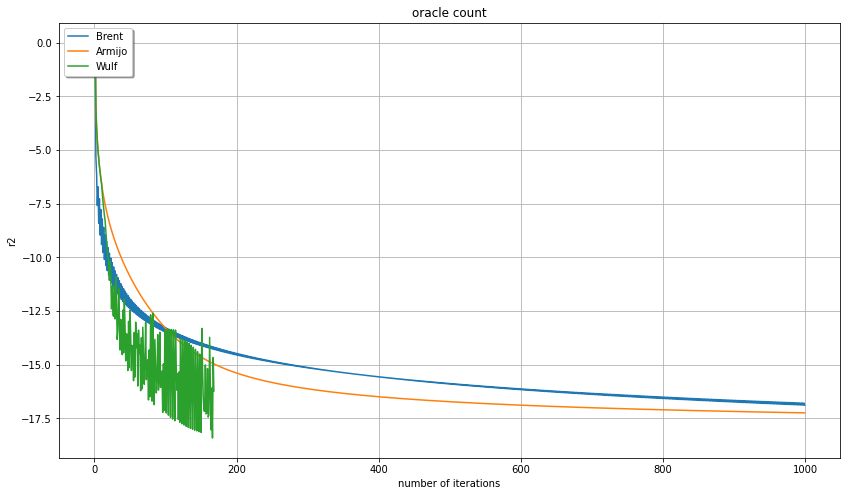

In [290]:
f = Oracle(X, y)

data_new = {
    "Brent": None,
    "Armijo": None,
    "Wulf": None,
}

plot_general(f, newton_plot, data_new)

#### Выводы:
- Метод Ньютона сошелся в значение более приближенное к точному по сравнению с градиентным спуском.
- На графиках видно, что Вульф сошелся в минимум быстрее Брента и Армихо.
- В целом, все методы дали чуть более точный результат по сравнению оптимального с оптимальным (отличие в третьем знаке после запятой) чем градиентный спуск, а сходимость заняла меньше времени.

## Пункт 6

#### Реализуем метод Hessian-Free Ньютон с квадрадитчным методом выбора точности.

### $$\eta_k = min(\frac{1}{8}, ||g_k||)$$

In [371]:
f = Oracle(X, y)
w = np.random.randint(0, 1, X.shape[1]).tolist()
w = np.array(w)

data_hf = {
    "Brent": None,
    "Armijo": None,
    "Wulf": None,
}

def get_f_optim_value(f, w):
    return scipy.optimize.minimize(f.value, w, jac=f.grad, tol=1e-8).fun

@counter
def line_search(f, w, d, m):
    
    if m == "Golden Section":
        a = golden_section_newton(f, w, d)    
        return a

    elif m == "Brent":
        a = brent(f, w, d)
        return a
    
    elif m == "Armijo":
        a = armijo_newton(f, w, d)
        return a
    
    elif m == "Wulf":
        a = wulff_newton(f, w, d)
        return a

@counter 
def hfnewton(f, w0, method, data_hf):
    
    ar1, ar2, hi_time, hi_oracle = [], [], [], []
    w = w0
    grad, hess, grad_start = f.grad(w), f.hessian(w), np.linalg.norm(f.grad(w0))
    r2, tol = 1, 1e-8
    f_optim_value = get_f_optim_value(f, w)
    m = method

    for k in range(1000):
        
        ar1.append(abs(f.value(w) - f_optim_value))
        ar2.append(r2)
        hi_time.append(line_search.time)
        hi_oracle.append(f.hessian_vec_product.count)
        r2 = (np.linalg.norm(grad) / grad_start)**2
        
        if (np.linalg.norm(grad)**2 / (grad_start)**2) <= tol:
            break

              
        eta = min(1 / 8, np.linalg.norm(grad))

        z = np.array([0 for i in range(len(grad))])
        d = -grad

        for i, x in enumerate(grad):
            u = f.hessian_vec_product(w, d)

            if d.T @ u <= 0:
                if not i:
                    z = d
                break

            a = (grad.T @ grad) / (d.T @ u)
            z = z + a * d
            prev_grad = grad
            grad = grad + (a * u)
            
            
            if np.linalg.norm(grad) <= eta * np.linalg.norm(grad):
                break
                
            
                
            b = (grad.T @ grad) / (prev_grad.T @ prev_grad)
            d = -grad + (b * d)
            
        a = line_search(f, w, -z, "Wulf")
        
        if z is None:
            z = 0.0001
        if a is None:
            a = 0.0001
                
        w = w + (a * z)
        grad = f.grad(w)
            
    data_hf[method] = {
            "ar1": np.log(ar1),
            "ar2": np.log(ar2),
            "hi_time": np.cumsum(hi_time),
            "hi_oracle": hi_oracle,
    }
                        
            
    return f.value(w)

In [324]:
f = Oracle(X, y)
w = np.random.randint(0, 1, X.shape[1]).tolist()
w = np.array(w)
data_hf = {
    "Wulf": None,
}
print('Function value', hfnewton(f, w, "Wulf", data_hf))
print("strategy: Wulf")
print('Time: ', hfnewton.time)
print('Oracle runs: ', f.hessian_vec_product.count)

Function value 0.2978913617792229
strategy: Wulf
Time:  29.101826087004156
Oracle runs:  13920


#### Выводы:
- Даже с использованием одной из самых быстрых linesearch стартегий время сходимости HF метода Ньютона составило 29 секунд. 
- Полученное значение function value наиболее точное из полученных нами ранее (разница с оптимальным решением в 5 знаке полсе запятой).

#### Построим графики для сравнения всех трех методов с использованием Вульфа в качестве linesearch стратегии. 

In [375]:
f = Oracle(X, y)

def plot_all(f, functions, data):
    
    w = np.random.randint(0, 1, X.shape[1]).tolist()
    w = np.array(w)
    plot_data1 = functions[0](f, w, data)
        
    plot_data2 = functions[1](f, w, data)
        
    plot_data3 = functions[2](f, w, data)
    
    for i in range(0, 2):
        for j in range(1, 3):
            plt.figure(figsize=(14,8))
            plt.grid(True)

            x_hf = plot_data1['Wulf'][i][0]
            y_hf = plot_data1['Wulf'][i][j]       
            plt.plot(x_hf, y_hf, label='Hessian-free Newton')

            x_nw = plot_data2['Wulf'][i][0]
            y_nw = plot_data2['Wulf'][i][j]       
            plt.plot(x_nw, y_nw, label='Newton')

            x_gd = plot_data3['Wulf'][i][0]
            y_gd = plot_data3['Wulf'][i][j]       
            plt.plot(x_gd, y_gd, label='Gradient Descent')


            if j == 1:
                plt.ylabel('r1')
            else:
                plt.ylabel('r2')

            if i == 0:
                plt.title("time")
                plt.xlabel('time taken')
            else:
                plt.title("oracle count")
                plt.xlabel('number of iterations')

            plt.legend(loc='upper left', shadow=True) 
            plt.show() 

In [376]:
f = Oracle(X, y)
w = np.random.randint(0, 1, X.shape[1]).tolist()
w = np.array(w)

def hfnewton_plot(f, w, data_hf):
    plot_data = {}
    
    for method in data_hf.keys():
        
        f.hessian_vec_product.__dict__["count"] = 0
        res_w = hfnewton(f, w, "Wulf", data_hf)
        print('Strategy: ', method)
        print('Time: ', hfnewton.time)
        print('Oracle runs: ', max(0, f.hessian_vec_product.count))
        print('Function value', res_w, '\n')
        plot_data[method] = []
        plot_data[method].append((data_hf[method]["hi_time"], data_hf[method]["ar1"], data_hf[method]["ar2"]))  
        plot_data[method].append((data_hf[method]["hi_oracle"], data_hf[method]["ar1"], data_hf[method]["ar2"]))
        plot_data[method].append((np.arange(len(data_hf[method]["ar1"])), data_hf[method]["ar1"]))
        plot_data[method].append((np.arange(len(data_hf[method]["ar2"])), data_hf[method]["ar2"]))
        
    return plot_data  

Strategy:  Wulf
Time:  33.62497559300391
Oracle runs:  6960
Function value 0.2978913617792229 

Strategy:  Wulf
Time:  1.2119983470038278
Oracle runs:  1432
Function value 0.29819573567508567 

Strategy:  Wulf
Time:  4.0729071170062525
Oracle runs:  14677
Function value 0.6504880830155256 



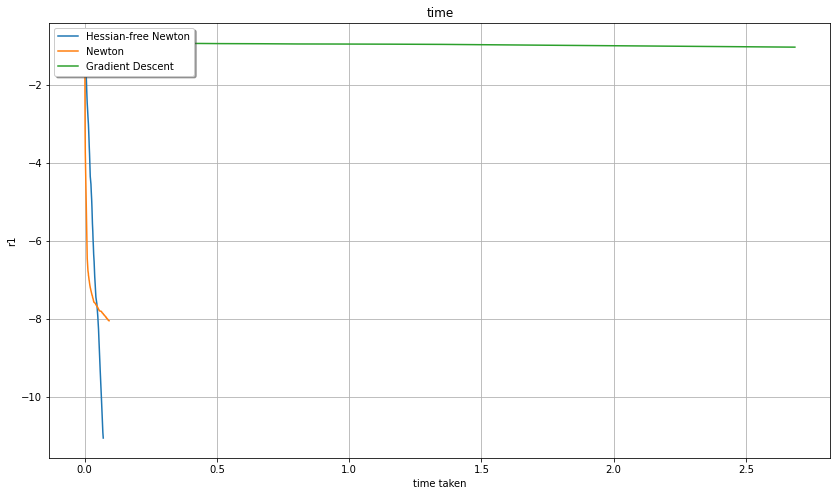

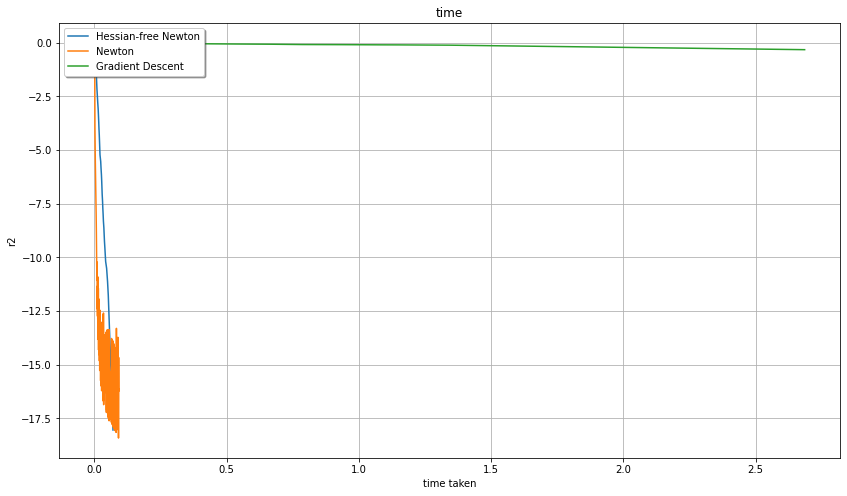

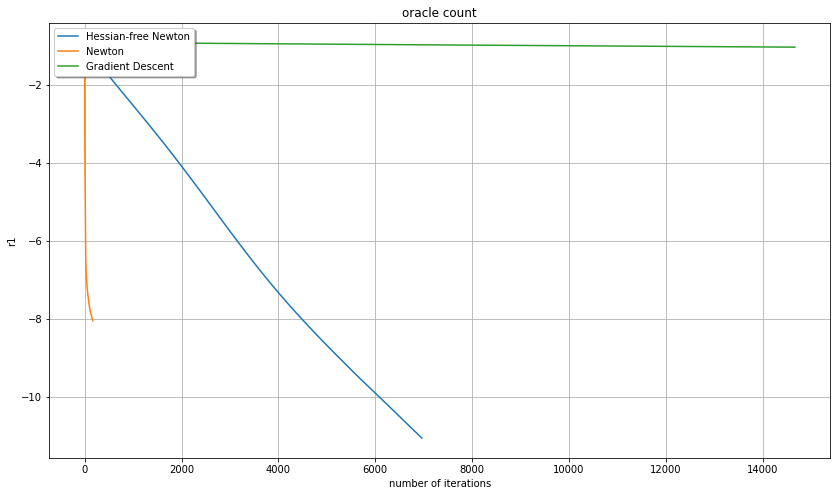

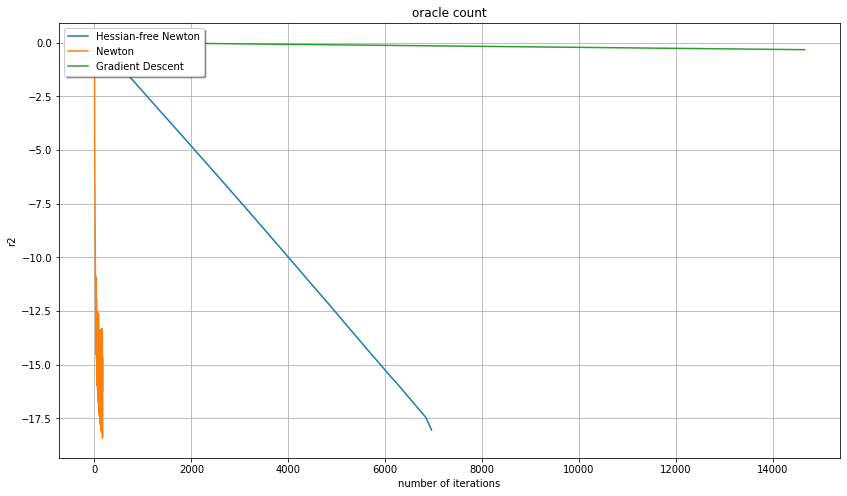

In [379]:
f = Oracle(X, y)

data = {
    "Wulf": None,
}

plot_all(f, [hfnewton_plot, newton_plot, grad_plot], data)

#### Выводы:
- Лучшую скорость сходимости из трех методов показал метод Ньютона: 1.21 секунда.
- Медленее всез отработал градиентых спуск, кроме того, в этот раз мы запустились из 0 и градиентный спуск показал многим менее точный результат.

### Протестируем наши методы на датасете brestcancer.

In [459]:
X, y = load_svmlight_file('breast-cancer_scale.txt')
X = scipy.sparse.hstack((np.array([1 for _ in range(X.shape[0])])[:,None], X)).A

# change -1 for 0 in y
for i in range(len(y)): 
    if y[i] == -1:
        y[i] = 0
        
w = np.random.randint(1, 2, X.shape[1]).tolist()
w = np.array(w)

#### Вычислим оптимальное значение для датасета.

In [397]:
f = Oracle(X, y)
def get_f_optim_value(f, w):
    return scipy.optimize.minimize(f.value, w, jac=f.grad, tol=1e-8).fun

w_optimal = get_f_optim_value(f, w)

print("Optimal value for dataset breast-cancer_scale:", w_optimal)

Optimal value for dataset breast-cancer_scale: -10.074534828288037


In [414]:
f = Oracle(X, y)

def plot_bc(f, functions, data):
    
    w = np.random.randint(1, 2, X.shape[1]).tolist()
    w = np.array(w)
    plot_data1 = functions[0](f, w, data)
        
    plot_data2 = functions[1](f, w, data)
    
    for i in range(0, 2):
        for j in range(1, 3):
            plt.figure(figsize=(14,8))
            plt.grid(True)

            x_hf = plot_data1['Wulf'][i][0]
            y_hf = plot_data1['Wulf'][i][j]       
            plt.plot(x_hf, y_hf, label='Newton')

            x_nw = plot_data2['Wulf'][i][0]
            y_nw = plot_data2['Wulf'][i][j]       
            plt.plot(x_nw, y_nw, label='Gradient Descent')


            if j == 1:
                plt.ylabel('r1')
            else:
                plt.ylabel('r2')

            if i == 0:
                plt.title("time")
                plt.xlabel('time taken')
            else:
                plt.title("oracle count")
                plt.xlabel('number of iterations')

            plt.legend(loc='upper left', shadow=True) 
            plt.show() 

#### Сравним скорость и точность сходимости градиентоного спуска и метода Ньютона со стратегий Вульфа на примере датасета breast-cancer.

Strategy:  Wulf
Time:  1.5924985239980742
Oracle runs:  14048
Function value -7.44508353503607 

Strategy:  Wulf
Time:  1.715411277997191
Oracle runs:  19032
Function value -9.916555521619804 



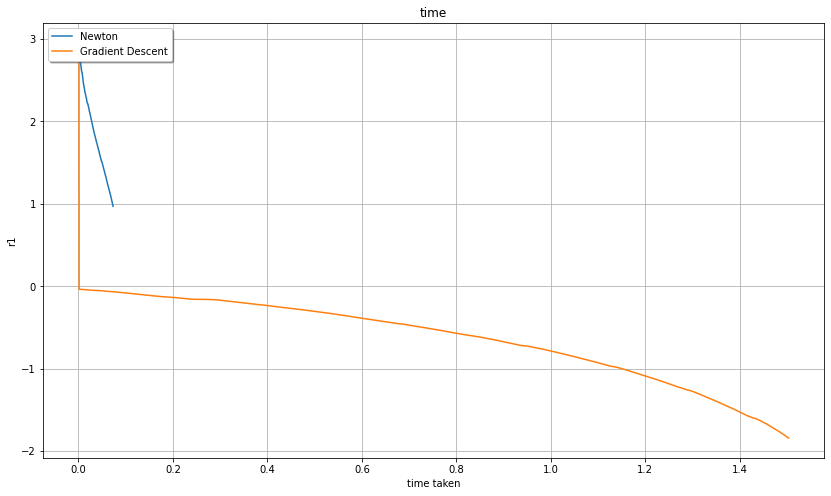

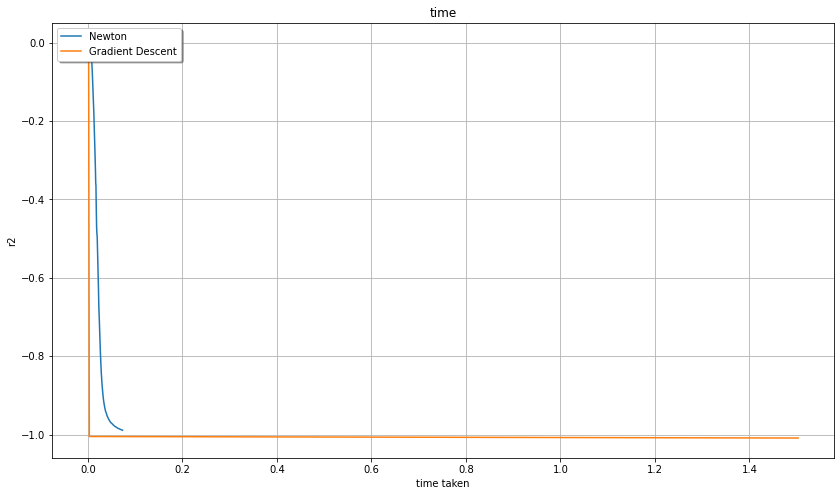

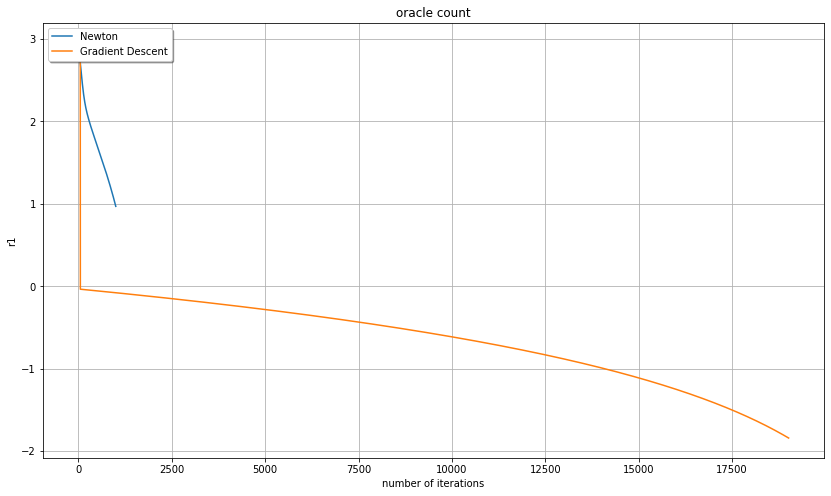

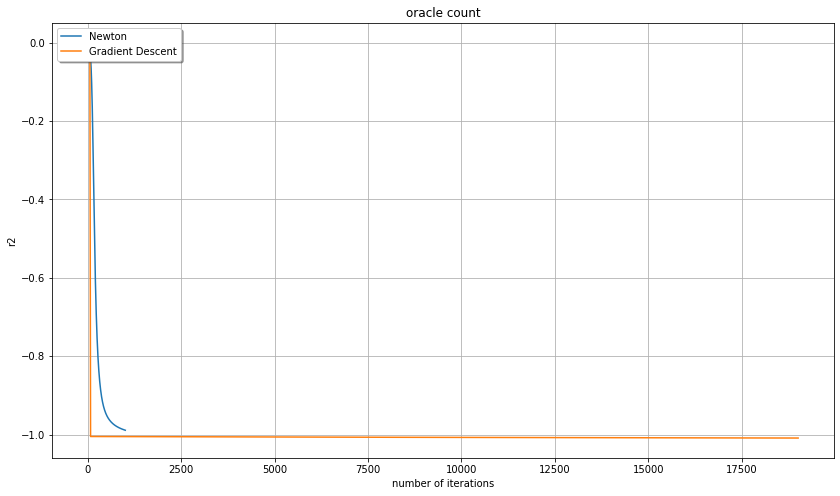

In [415]:
f = Oracle(X, y)

data = {
    "Wulf": None,
    
}

plot_bc(f, [newton_plot, grad_plot], data)

#### Выводы:
- Видим, что метод Ньютона по прежнему сходится быстрее градиентного спуска, однако, в данном случае значительно проигрывает в точности полученного результата. 
- Результат сходимости для обоих методов в большой степени зависит от выбора начальной. Для представленных графиков в качестве начальной был выбран единичный вектор $w$.

### Протестируем методы на симулированных данных 

In [485]:
f = Oracle(X, y)

X = [[1] for i in range(1000)]
y = [0 for i in range (1000)]
a, b = random.uniform(-1, 1), random.uniform(-1, 1)
for i in range(1000):
    x = random.gauss(0, 1)
    X[i].append(x)
    if a * x + b >= 0:
        y[i] = 1
    else:
        y[i] = 0
X = np.array(X)
y = np.array(y)
w = np.random.randint(0, 1, X.shape[1]).tolist()
w = np.array(w)



def get_f_optim_value(f, w):
    return scipy.optimize.minimize(f.value, w, jac=f.grad, tol=1e-8).fun

w_optimal = get_f_optim_value(f, w)
print("Optimal value for simulated dataset:", w_optimal)

Optimal value for simulated dataset: -2.4969508723540163e-09


#### Градиентный спуск:

Strategy:  Golden Section
Time:  5.9598288139968645
Oracle runs:  95044
Function value 0.008875738463171095 

Strategy:  Brent
Time:  0.08401381400472019
Oracle runs:  879
Function value 0.003818914508652238 

Strategy:  Armijo
Time:  3.6540190279920353
Oracle runs:  49044
Function value 0.053582712546061256 

Strategy:  Wulf
Time:  1.08685467801115
Oracle runs:  11088
Function value 0.005085595632041893 

Strategy:  Lipschitz
Time:  0.34888156098895706
Oracle runs:  3044
Function value 0.04922188660918094 



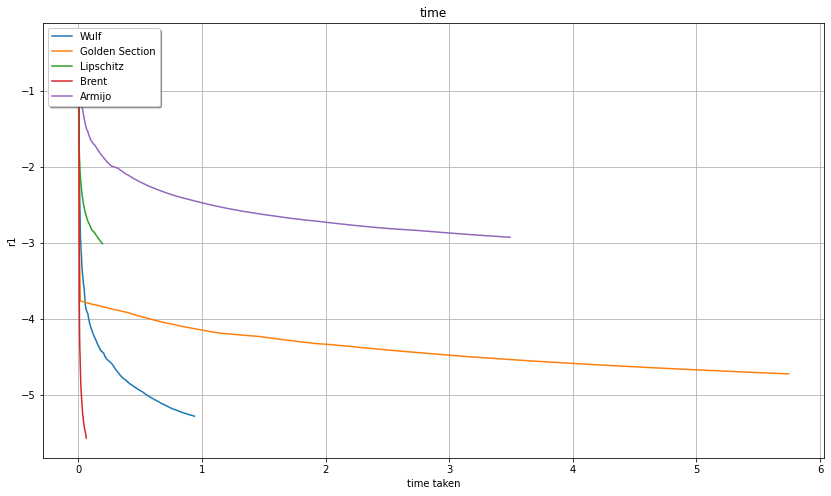

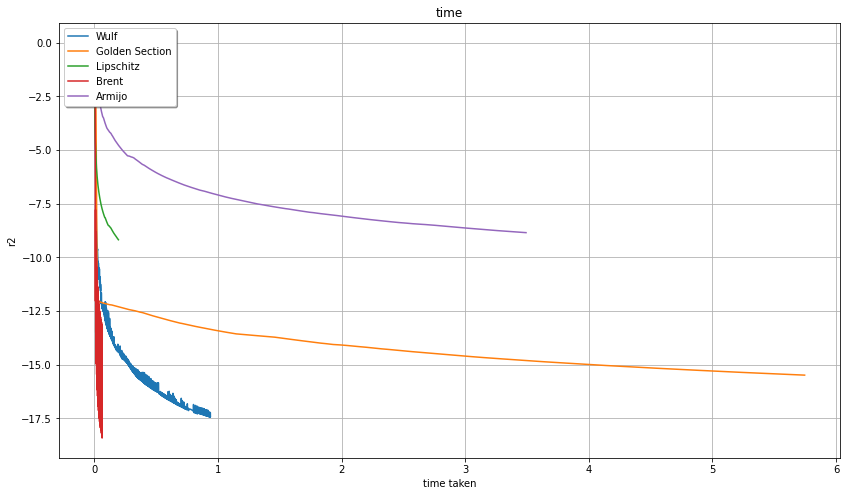

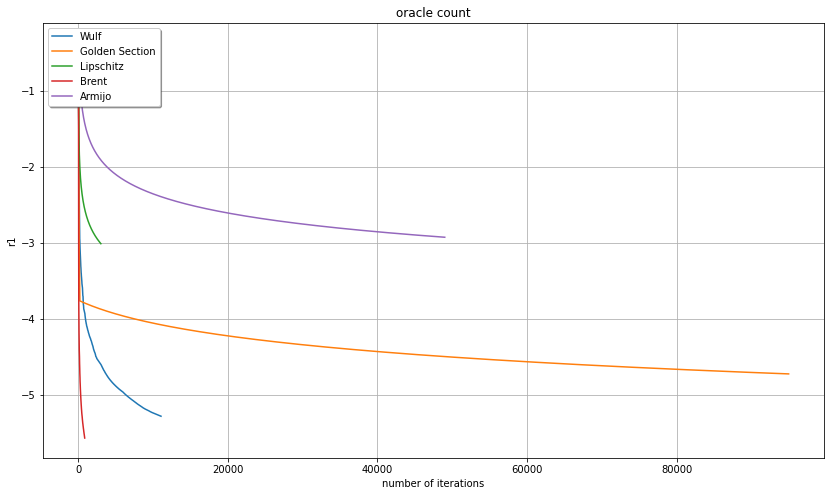

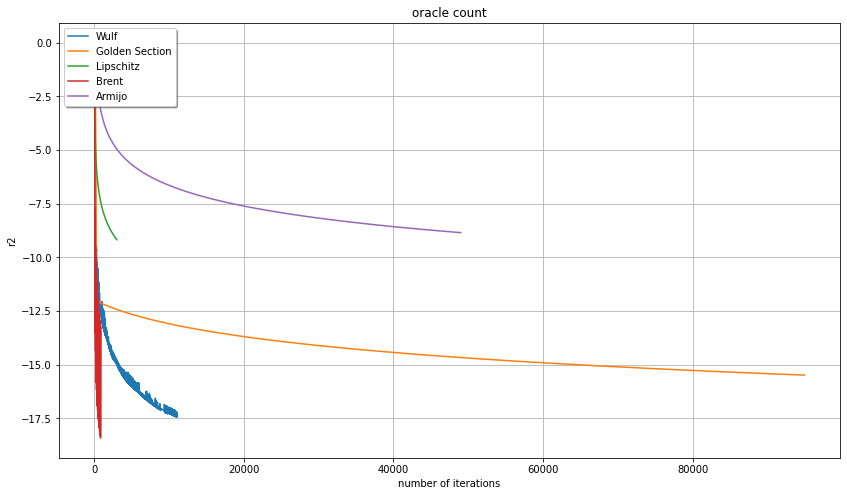

In [486]:
data = {
    "Golden Section": None,
    "Brent": None,
    "Armijo": None,
    "Wulf": None,
    "Lipschitz": None,
}

plot_general(f, grad_plot, data)

#### Метод Ньютона:

Strategy:  Brent
Time:  0.04785818699747324
Oracle runs:  271
Function value 0.0035448415831503604 

Strategy:  Armijo
Time:  0.4508506220008712
Oracle runs:  3044
Function value 0.03246128833177761 

Strategy:  Wulf
Time:  1.3518850979889976
Oracle runs:  14044
Function value 0.6427613344129459 



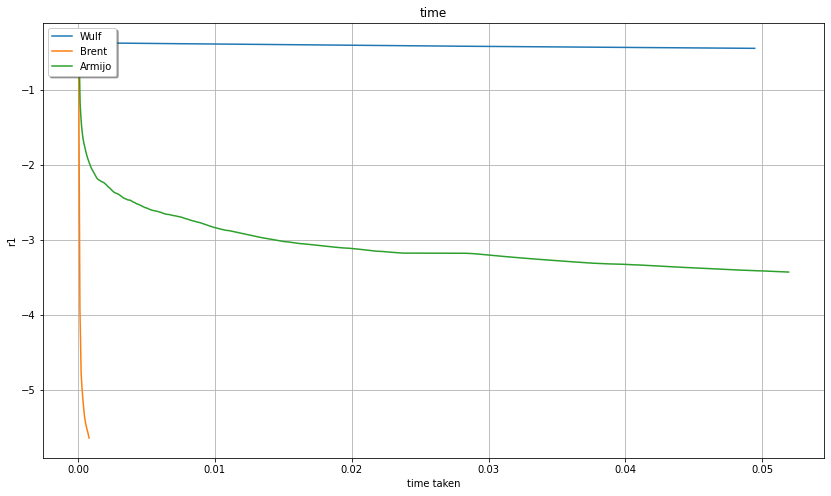

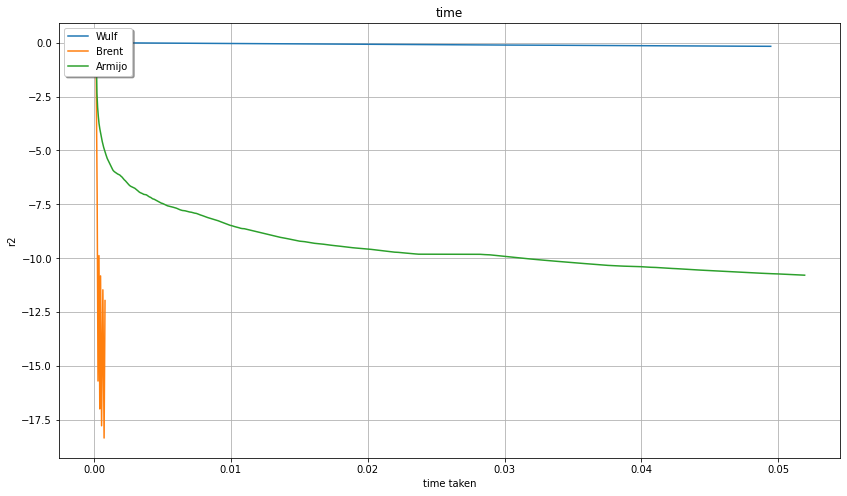

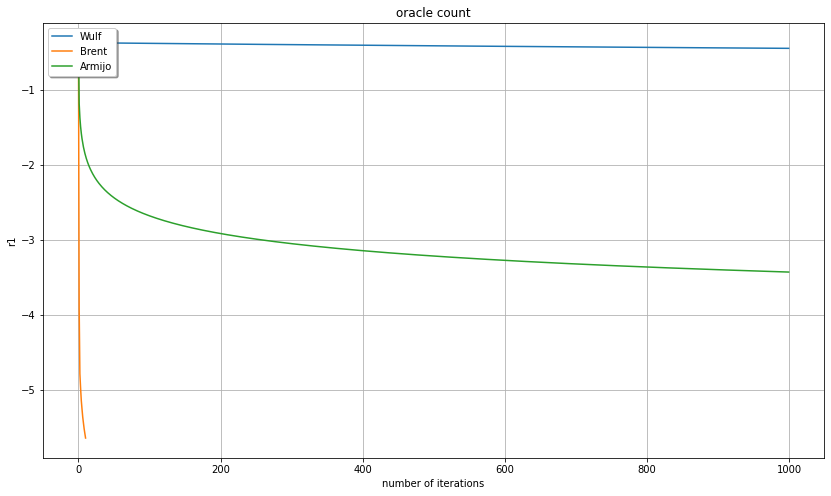

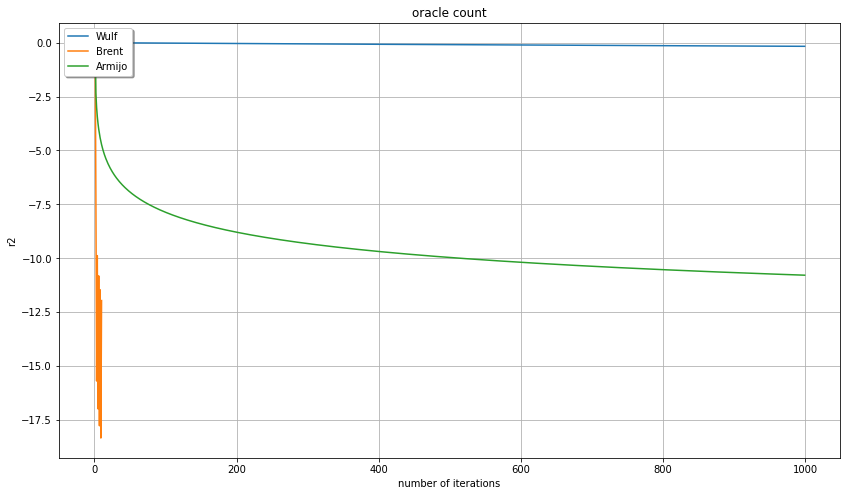

In [487]:
data_new = {
    "Brent": None,
    "Armijo": None,
    "Wulf": None,
}

plot_general(f, newton_plot, data_new)

#### Метод Ньютона и HF-Newton с использованием стратегии Вульфа:

Strategy:  Wulf
Time:  4.570074205999845
Oracle runs:  2000
Function value 0.6930175802143873 

Strategy:  Wulf
Time:  1.4685667309968267
Oracle runs:  14044
Function value 0.6427613344129459 

Strategy:  Wulf
Time:  1.1151266710076015
Oracle runs:  11088
Function value 0.005085595632041893 



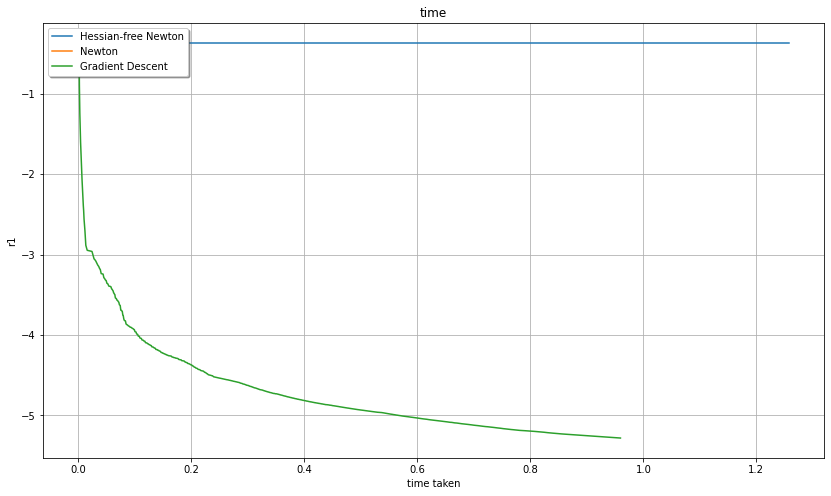

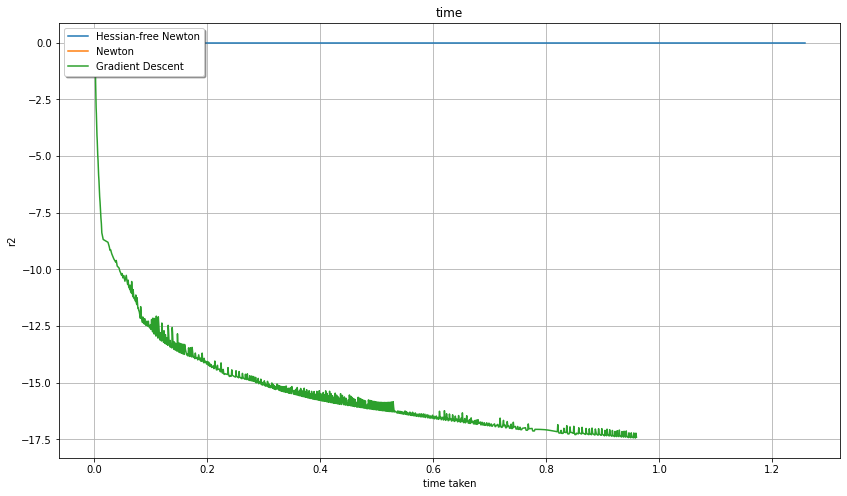

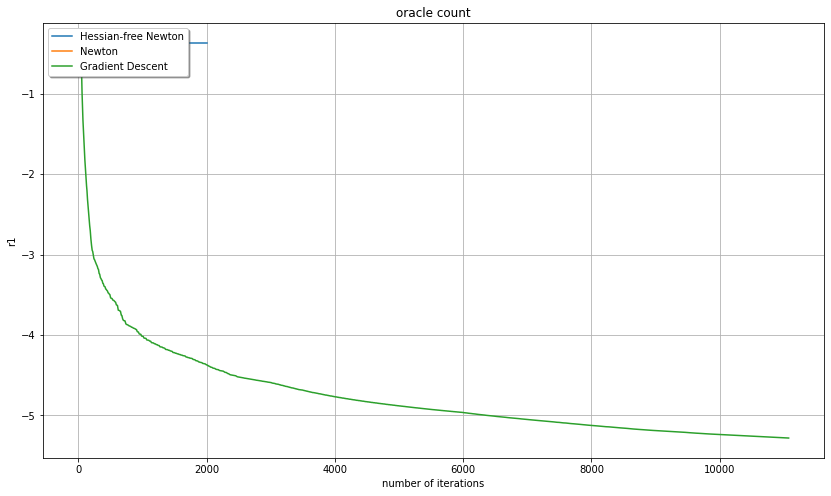

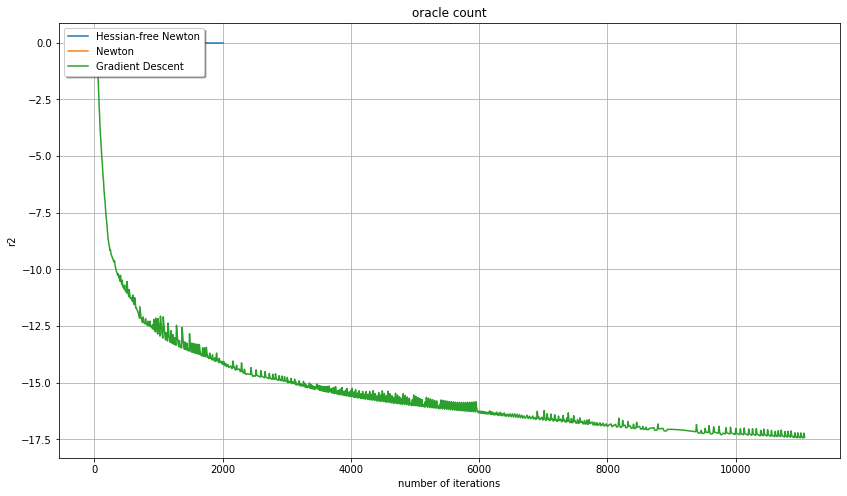

In [488]:
data = {
    "Wulf": None,
}

plot_all(f, [hfnewton_plot, newton_plot, grad_plot], data)

#### Выводы:
- На симулированных данных все 3 метода показали менее точный резултат чем на датасете a1a и breast-cancer, однако мы можем наблюдать схожую динамику по точности и скорости сходимости рассмотренных нами linesearch стратегий: стратегия золотого сечения работает медленне всех, Брент Липшец и Вульф обладают самой быстрой скоростью сходимсоти. 